## Introducción a GANs

### Referencias
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2020. Generative adversarial networks. Communications of the ACM, 63(11), pp.139-144. [link](https://arxiv.org/abs/1406.2661)

- ...

### Que pasos debemos seguir para entrenar una GAN?
- Cargar datos, transformarlos en formato necesario para pytorch. $t_{train}$ va a tener transformaciones diferentes a $t_{test}$, por que? 
- A los datos de entrenamiento debemos dividirlos una vez mas para usar elementos de validación durante el entrenamiento.
- Definir arquitectura de nuestras redes, la red generadora ($G$), evaluadora ($D$) (Ver models.py)
- Definir métodos funciones de error, optimizador y métricas de evaluación para el entrenamiento paralelo de ambas redes.

In [1]:
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torchvision.utils as vutils

import PIL

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0), fill=255),
    tfs.Resize((32, 32)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

transforms_test = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0), fill=255),
    tfs.Resize((32, 32)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

train_data = datasets.ImageFolder(
    "../data/train/", transform=tfs.Compose(transforms_train)
)

test_data = datasets.ImageFolder(
    "../data/test/", transform=tfs.Compose(transforms_test)
)

In [2]:
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)

### Que dispositivo tenemos disponible?

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo disponible: {device}')

Dispositivo disponible: cuda


In [5]:
from models.generator import _G
from models.discriminator import _D
from models.gan import GAN
import PIL.ImageOps

In [6]:
from torchsummary import summary

G = _G(input_h_w=112, latent_v=64).to(device)
summary(G, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          66,560
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
            Linear-4               [-1, 100352]     102,860,800
       BatchNorm1d-5               [-1, 100352]         200,704
              ReLU-6               [-1, 100352]               0
   ConvTranspose2d-7           [-1, 64, 56, 56]         131,136
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
  ConvTranspose2d-10          [-1, 1, 112, 112]           1,025
          Sigmoid-11          [-1, 1, 112, 112]               0
Total params: 103,262,401
Trainable params: 103,262,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00


In [7]:
D = _D(input_h_w=112).to(device)
summary(D, (1, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,088
         LeakyReLU-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 128, 28, 28]         131,200
       BatchNorm2d-4          [-1, 128, 28, 28]             256
         LeakyReLU-5          [-1, 128, 28, 28]               0
            Linear-6                 [-1, 1024]     102,761,472
       BatchNorm1d-7                 [-1, 1024]           2,048
         LeakyReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 1]           1,025
          Sigmoid-10                    [-1, 1]               0
Total params: 102,897,089
Trainable params: 102,897,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.38
Params size (MB): 392.52
E

In [8]:
def initialize():
    '''Funcion de inicialización. Creamos el modelo, definimos el optimizador y la función de perdida'''
    D = _D(input_h_w=32).to(device)
    G = _G(input_h_w=32, latent_v=64).to(device)
    optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()


    return D, G, optimizer_G, optimizer_D, criterion

In [9]:
batch_size = 64
z_dim = 64
output_dir = 'output/'
PRINT_FREQ = 10
FAKE_IMG_FNAME = "fake_sample_epoch_{:04d}.png"
REAL_IMG_FNAME = "real_sample_epoch_{:04d}.png"
LOGS_FNAME = "logs.tsv"
PLOT_FNAME = "plot.svg"
SAMPLES_FNAME = "samples.svg"
CKPT_PREFIX = "networks"
alpha = 0.98
epochs = 200

real_labels = torch.ones(batch_size, device=device)
fake_labels = torch.zeros(batch_size, device=device)
fixed_noise = torch.randn(batch_size, z_dim, device=device)

D, G, optimizer_G, optimizer_D, criterion = initialize()

def get_noise():
    return torch.randn(batch_size, z_dim, device=device)

# The main function, processing a batch of examples
def step(engine, batch):
    # unpack the batch. It comes from a dataset, so we have <images, labels> pairs. Discard labels.
    real, _ = batch
    real = real.to(device)

    # -----------------------------------------------------------
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    D.zero_grad()

    # train with real
    
    output = D(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

    errD_real.backward()

    # get fake image from generator
    noise = get_noise()
    fake = G(noise)

    # train with fake
    output = D(fake.detach())
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()

    errD_fake.backward()

    # gradient update
    errD = errD_real + errD_fake
    optimizer_D.step()

    # -----------------------------------------------------------
    # (2) Update G network: maximize log(D(G(z)))
    G.zero_grad()

    # Update generator. We want to make a step that will make it more likely that discriminator outputs "real"
    output = D(fake)
    errG = criterion(output, real_labels)
    D_G_z2 = output.mean().item()

    errG.backward()

    # gradient update
    optimizer_G.step()

    return {"errD": errD.item(), "errG": errG.item(), "D_x": D_x, "D_G_z1": D_G_z1, "D_G_z2": D_G_z2}


In [10]:
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

In [11]:
# ignite objects
trainer = Engine(step)
checkpoint_handler = ModelCheckpoint(output_dir, CKPT_PREFIX, n_saved=10, require_empty=False)
timer = Timer(average=True)

# attach running average metrics
monitoring_metrics = ["errD", "errG", "D_x", "D_G_z1", "D_G_z2"]
RunningAverage(alpha=alpha, output_transform=lambda x: x["errD"]).attach(trainer, "errD")
RunningAverage(alpha=alpha, output_transform=lambda x: x["errG"]).attach(trainer, "errG")
RunningAverage(alpha=alpha, output_transform=lambda x: x["D_x"]).attach(trainer, "D_x")
RunningAverage(alpha=alpha, output_transform=lambda x: x["D_G_z1"]).attach(trainer, "D_G_z1")
RunningAverage(alpha=alpha, output_transform=lambda x: x["D_G_z2"]).attach(trainer, "D_G_z2")

# attach progress bar
pbar = ProgressBar()
pbar.attach(trainer, metric_names=monitoring_metrics)

@trainer.on(Events.ITERATION_COMPLETED(every=PRINT_FREQ))
def print_logs(engine):
    fname = output_dir + LOGS_FNAME
    columns = ["iteration"] + list(engine.state.metrics.keys())
    values = [str(engine.state.iteration)] + [str(round(value, 5)) for value in engine.state.metrics.values()]
    #print('fname', fname)
    with open(fname, "a") as f:
        if f.tell() == 0:
            print("\t".join(columns), file=f)
        print("\t".join(values), file=f)
    message = f"[{engine.state.epoch}/{epochs}][{engine.state.iteration % len(train_loader)}/{len(train_loader)}]"
    for name, value in zip(columns, values):
        message += f" | {name}: {value}"

    #pbar.log_message(message)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def save_fake_example(engine):
    fake = G(fixed_noise)
    path = output_dir + FAKE_IMG_FNAME.format(engine.state.epoch)
    vutils.save_image(fake.detach(), path, normalize=True)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def save_real_example(engine):
    img, y = engine.state.batch
    path = output_dir + REAL_IMG_FNAME.format(engine.state.epoch)
    vutils.save_image(img, path, normalize=True)

# adding handlers using `trainer.add_event_handler` method API
trainer.add_event_handler(
    event_name=Events.EPOCH_COMPLETED, handler=checkpoint_handler, to_save={"netG": G, "netD": D}
)

# automatically adding handlers via a special `attach` method of `Timer` handler
timer.attach(
    trainer,
    start=Events.EPOCH_STARTED,
    resume=Events.ITERATION_STARTED,
    pause=Events.ITERATION_COMPLETED,
    step=Events.ITERATION_COMPLETED,
)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def print_times(engine):
    #pbar.log_message(f"Epoch {engine.state.epoch} done. Time per batch: {timer.value():.3f}[s]")
    timer.reset()

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def create_plots(engine):
    try:
        import matplotlib as mpl

        mpl.use("agg")

        import matplotlib.pyplot as plt
        import pandas as pd

    except ImportError:
        warnings.warn("Loss plots will not be generated -- pandas or matplotlib not found")

    else:
        df = pd.read_csv(output_dir + '/' + LOGS_FNAME, delimiter="\t", index_col="iteration")
        _ = df.plot(subplots=True, figsize=(20, 20))
        _ = plt.xlabel("Iteration number")
        fig = plt.gcf()
        path = output_dir + PLOT_FNAME

        fig.savefig(path)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        warnings.warn("KeyboardInterrupt caught. Exiting gracefully.")

        create_plots(engine)
        checkpoint_handler(engine, {"netG_exception": G, "netD_exception": D})

    else:
        raise e

# Setup is done. Now let's run the training
trainer.run(train_loader, epochs)


/home/pablo1n7/miniconda3/envs/cursoEsp/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/pablo1n7/miniconda3/envs/cursoEsp/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


State:
	iteration: 3000
	epoch: 200
	epoch_length: 15
	max_epochs: 200
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [41]:
from PIL import Image, ImageSequence
import imageio
import glob


In [48]:
lista_imagenes = [ Image.open(x) for x in sorted(glob.glob(output_dir+'fake_*.png'))]

In [52]:
archivo_salida = output_dir+'GAN_generate_animation.gif'
imageio.mimsave(archivo_salida, lista_imagenes, 'GIF')

#### Podemos observar el progreso de la red generadora a medida que pasan las iteraciones 
<img src=output/GAN_generate_animation.gif/>

### Como podemos evaluar los artefactos generados? 
- Mostrar métricas clásicas y geométricas (FID, InceptionScore).
- Comparar test estadisticos de distribuciones de datos reales y generados.
- Usar clasificadores para datos reales.

In [12]:
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = tfs.ToPILImage()(img)
        pil_img = pil_img.convert("RGB")
        resized_img = pil_img.resize((128,128), Image.BILINEAR)
        arr.append(tfs.ToTensor()(resized_img))
    return torch.stack(arr)
    
def evaluation_step(engine, batch):
    real, _ = batch
    with torch.no_grad():
        noise = get_noise()
        G.eval()
        fake_batch = G(noise)
        fake = interpolate(fake_batch)
        real = interpolate(real)
        return fake, real

In [13]:
from ignite.metrics import FID, InceptionScore

In [14]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [15]:
evaluator = Engine(evaluation_step)

imgs_fake = []
imgs_reals = []

@evaluator.on(Events.ITERATION_COMPLETED(every=1))
def print_logs(engine):
    global imgs_fake
    global imgs_reals
    fake, real = engine.state.output
    imgs_fake += fake
    imgs_reals+= real
    

In [16]:
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [17]:
evaluator.run(test_loader)
metrics = evaluator.state.metrics
fid_score = metrics['fid']
is_score = metrics['is']

## Inseption Score

In [18]:
is_score

8.685636714378656

## FID Score

In [19]:
fid_score

0.12916592605491817

## Espacio PCA

In [20]:
import numpy as np

In [21]:
imgs_reals_list =  [i.numpy().tolist() for i in (imgs_reals)]
imgs_fake_list =  [i.numpy().tolist() for i in (imgs_fake)]

In [22]:
len(imgs_fake_list)

256

In [23]:
all_data = imgs_reals_list + imgs_fake_list

In [24]:
all_data = np.array(all_data)

In [25]:
from sklearn.decomposition import PCA

all_data = all_data.reshape(512, -1)

pca = PCA(n_components=2).fit(all_data)
Xp = pca.transform(all_data)

In [26]:
Xp.shape

(512, 2)

In [27]:
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.close()

In [28]:
%matplotlib inline

In [29]:
colors = np.zeros(256).tolist() + np.ones(256).tolist()

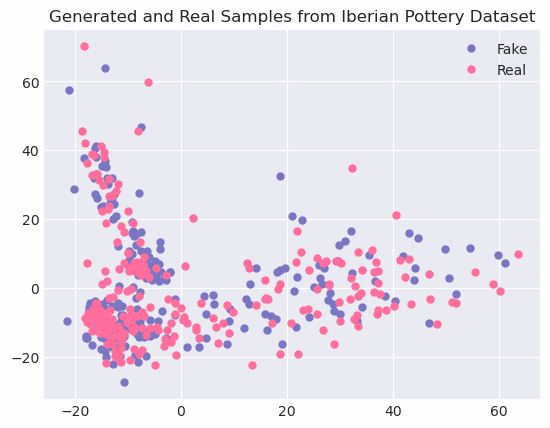

In [31]:
import pandas as pd

name_dic = {1.0:'Real', 0:'Fake'}


pca_df = pd.DataFrame(Xp, columns=['PC1', 'PC2'])
#labels = pd.DataFrame(colors, columns=['class'])
labels = pd.DataFrame([name_dic[c] for c in colors], columns=['class'])
pca_df = pd.concat([pca_df, labels], axis=1)

groups = pca_df.groupby('class')


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
        ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name, alpha=1)

plt.title('Generated and Real Samples from Iberian Pottery Dataset')
ax.legend()

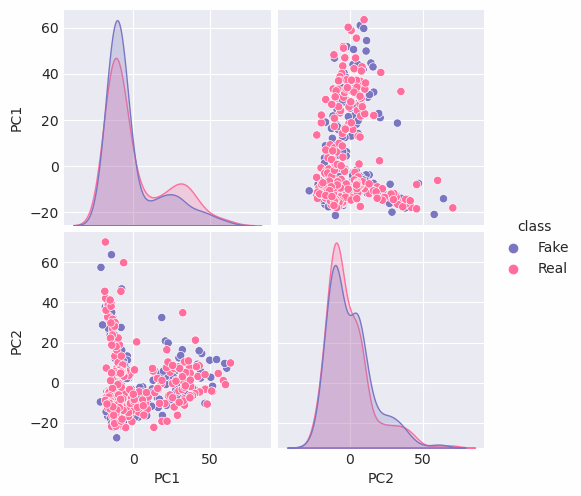

In [32]:
import seaborn as sns
sns.pairplot(pca_df, hue='class')

## Geometric Score

In [33]:
!git clone https://github.com/KhrulkovV/geometry-score.git

fatal: destination path 'geometry-score' already exists and is not an empty directory.


In [34]:
import sys
sys.path.append('./geometry-score/')
import gs

In [35]:
all_data[all_data>0.5] = 1
all_data[all_data<0.5] = 0

In [36]:
y_1 = all_data[0:256]
x_1 = all_data[256:]

In [37]:
rlts_fake = gs.rlts(x_1, gamma=1.0/128, n=x_1.shape[0])
mrlt_fake = np.mean(rlts_fake, axis=0)

Done 0/256
Done 10/256
Done 20/256
Done 30/256
Done 40/256
Done 50/256
Done 60/256
Done 70/256
Done 80/256
Done 90/256
Done 100/256
Done 110/256
Done 120/256
Done 130/256
Done 140/256
Done 150/256
Done 160/256
Done 170/256
Done 180/256
Done 190/256
Done 200/256
Done 210/256
Done 220/256
Done 230/256
Done 240/256
Done 250/256


In [38]:
rlts_real = gs.rlts(y_1, gamma=1.0/128, n=y_1.shape[0])
mrlt_real = np.mean(rlts_real, axis=0)

Done 0/256
Done 10/256
Done 20/256
Done 30/256
Done 40/256
Done 50/256
Done 60/256
Done 70/256
Done 80/256
Done 90/256
Done 100/256
Done 110/256
Done 120/256
Done 130/256
Done 140/256
Done 150/256
Done 160/256
Done 170/256
Done 180/256
Done 190/256
Done 200/256
Done 210/256
Done 220/256
Done 230/256
Done 240/256
Done 250/256


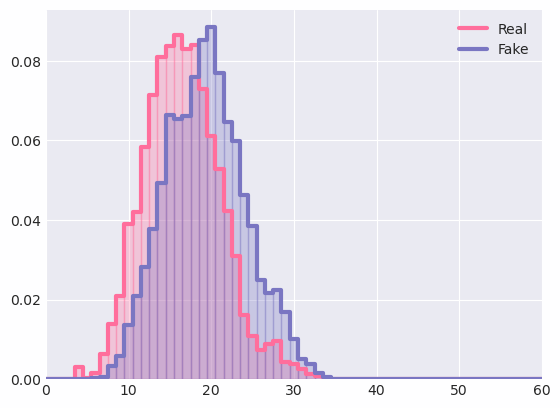

In [39]:
gs.fancy_plot(mrlt_real, label='Real', color='#ff6e9c')
gs.fancy_plot(mrlt_fake, label='Fake', color='#7a76c2')
plt.xlim([0, 60])
plt.legend()

In [40]:
print('GS-SCORE', gs.geom_score(rlts_fake, rlts_real))


GS-SCORE 0.010915607655712955


### Ejercicios
- ...